In [8]:
import os
import pickle

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## A small hack to make sure we are in the correct folder
cwd = os.getcwd()
folder_name = os.path.basename(cwd)
if folder_name != 'uas-package':
    os.chdir('../')

from simuas.Util import Package

%matplotlib inline

## Load Data
Here we will load our saved data from the simulation. This is a list (array) where every element contains data about one replication. Each replication contains the following:

1. Time series of number of charging stations used. 
2. Time series of number of packages waiting for a UAS (queue length).
3. Time series for the number of batteries available in the 'battery bank' resource.
4. Time series for the number of UAS fully available in the 'UAS bank' resource.
5. A list of all pacakges delivered. Each pacakge holds detailed information such as - time to wait for a UAS, flight time, total deliver time, etc.
6. An error list. Each element contains an error record (low battery, uas collison)

In [9]:
raw_data = pickle.load( open( "./data/repl_results.p", "rb" ) )


In [34]:
def plot_historgram(raw_data, i):
    """This function plots historgrams for one replication (indexed by i)
    """
    data = raw_data[i]
    package_df = pd.DataFrame(data['packages'], columns=Package._fields).dropna()
    
    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    subplots = [('uas_queue', 'Package Queue (# Waiting for UAS)'),('battery_bank', 'Number of Available Batteries'), 
     ('charging_stations', 'In Use Battery Charging Stations') ]
    
    sns.distplot(package_df['uas_wait'], kde=False, ax=ax[0])
    ax[0].set_title('Package Wait Time (for UAS)')
    ax[0].set_ylabel('# of Pacakges')
    ax[0].set_xlabel('Minutes')
    
    for i, (key, title) in enumerate(subplots):
        bb = data[key]
        sns.distplot(list(bb.keys()), bins=25, ax=ax[i+1], kde=False, hist_kws={'weights': list(bb.values())})
        ax[i+1].set_title(title)
        ax[i+1].set_ylabel('Minutes')
    
    fig.subplots_adjust(wspace=.25)
    


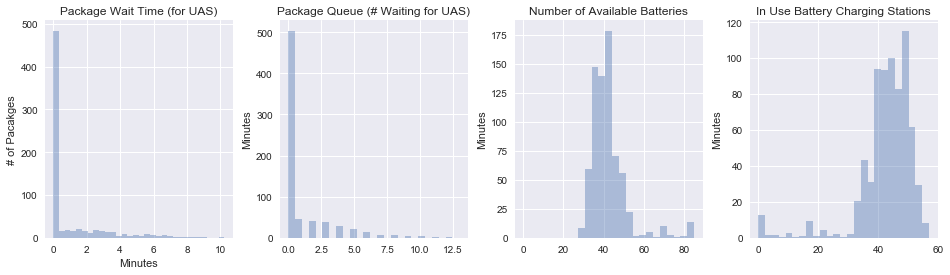

In [35]:
plot_historgram(raw_data, 0) # plot some data for FIRST replication

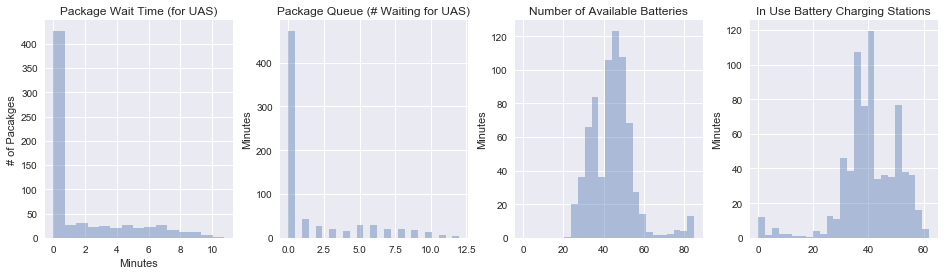

In [36]:
plot_historgram(raw_data, 1) # plot some data for SECOND replication

## Replciations and CI
Here are some questions about replications and Confidence Intervals (CI)


### Inside a Replication

Every replication has a distribtuion of values for some metric that I desire. It should be be clear that the values may be in continous space (queue length), or may be discrete (wait time for for customer service). Continous space means we are recording some metric every time step (queue length), while discrete means we have a discrete object/sample that has a numeric real value (wait time).

For example, queue length varies over time for some service I desire. Lets say 25% of time it is length 1, 50% length 2, and 25% length 3.
This distribution can be estimated with a mean (weighted average of time). But how do you estimate the variance? The CI? Remember we are still talking about 1 replication still. 

If the values were for wait time for a package to have an availble UAS (First graph); the mean, standard deviation, and CI would be:

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} n \\
\sigma = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})^2 \\
\mu = \bar{x} \pm \underbrace{z \cdot \frac{\sigma}{\sqrt{n}}}_{CI}
$$

However, I'm not sure how I would calculate these metrics (besides mean) for queue length. How do you desribe how something varies over **time** and not **samples**.


### Outside Replicatons


Now lets say I replicate the experiment exactly 10 times.
Each one of those replications will have its *own* distribuiton for a variable of interest and have its own characterization of 
the mean and the variance.

We learned in class that we can estimate the stabdard error (SE, which will give us a CI on the mean) using the following formula

$$
S^2(n) = \frac{1}{n-1} \sum_{i=1}^{n} (X_i - \bar{X})^2 \\
SE = \sqrt{S^2(n) / n}
$$

We use this technique to give us a CI around mean of some variable. So basically get the mean of a variable for each replication $i$, call this $\bar{x}_i$. Then these become 'sample' means, and the variance of these samples means can help provide a CI. Note that this variance tells us nothing of the variance of the *population*, just the variance of the *means* of replications.

### Summing up

I guess my question in the end is:

1. Look at the above graphs. 4 graphs for 4 variables of interest. 2 Sets, 1 set for each replication #1 and #2. 
2. What statistics should be used to summarize these variables.  What statistical techniques?
